In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [3]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
query_dir = 'queries'

In [5]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [6]:
query_client = bigquery.Client()

In [7]:
request = queries['combined_analysis_data.sql']

In [8]:
data = query_client.query(request).to_dataframe()

In [9]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791 entries, 0 to 4240
Data columns (total 22 columns):
ad_id                 3791 non-null int64
apt_id                2622 non-null object
new_building          3791 non-null bool
num_bedrooms          3732 non-null float64
floor                 3114 non-null float64
primary_size          3791 non-null float64
total_size            3699 non-null float64
price                 3791 non-null float64
property_type         3791 non-null object
ownership_type        3791 non-null object
construction_year     3788 non-null float64
energy_character      1433 non-null object
common_expenses       883 non-null float64
brokerage_expenses    1166 non-null float64
common_wealth         637 non-null float64
common_debt           1043 non-null float64
time_s                3651 non-null float64
lat                   3651 non-null float64
lng                   3651 non-null float64
address               3791 non-null object
short_description     379

# Feature Engineering
## Energy Letter and Color

In [11]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

## Post Codes

In [12]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [13]:
data['post_code'] = data.address.apply(get_postcode_from_address)

## Settlement Names

In [14]:
post_codes_no = pd.read_csv('post_codes_no.csv', dtype={'post_code': str}).set_index('post_code')

In [15]:
post_codes_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5057 entries, 0001 to 9991
Data columns (total 4 columns):
name               5057 non-null object
municipality_id    5057 non-null int64
municipality       5057 non-null object
type               5057 non-null object
dtypes: int64(1), object(3)
memory usage: 197.5+ KB


In [16]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['municipality']

## Oslo Neighborhood Names

In [17]:
post_codes_osl = pd.read_csv('post_codes.csv', dtype={'post_code':str}).set_index('post_code', drop=True)

In [18]:
post_codes_osl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0001 to 2185
Data columns (total 5 columns):
lat                  995 non-null float64
lng                  995 non-null float64
municipality         995 non-null object
neighborhood_name    940 non-null object
population           590 non-null float64
dtypes: float64(3), object(2)
memory usage: 46.6+ KB


In [19]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

## Combine Oslo Neighborhood Names and Settlement Names

In [20]:
data['area_name'] = [s_n if s_n != 'OSLO' else n_n for s_n, n_n in zip(data['settlement_name'], data['neighborhood_name'])]

In [21]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'OSLO' else False)

# Data Imputation

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791 entries, 0 to 4240
Data columns (total 29 columns):
ad_id                 3791 non-null int64
apt_id                2622 non-null object
new_building          3791 non-null bool
num_bedrooms          3732 non-null float64
floor                 3114 non-null float64
primary_size          3791 non-null float64
total_size            3699 non-null float64
price                 3791 non-null float64
property_type         3791 non-null object
ownership_type        3791 non-null object
construction_year     3788 non-null float64
energy_character      1433 non-null object
common_expenses       883 non-null float64
brokerage_expenses    1166 non-null float64
common_wealth         637 non-null float64
common_debt           1043 non-null float64
time_s                3651 non-null float64
lat                   3651 non-null float64
lng                   3651 non-null float64
address               3791 non-null object
short_description     379

## Impute Number Of Bedrooms

In [23]:
data['primary_size_bin'] = pd.cut(data['primary_size'], bins=[-np.inf, 30, 40, 50, 60, 70, 80, 100, 150, 200, np.inf])

In [24]:
num_bedrooms_grouping = data.groupby(['primary_size_bin'])['num_bedrooms'].median()

In [25]:
data['num_bedrooms'] = [num_bedrooms_grouping.loc[size_bin] if np.isnan(num_bedr) else num_bedr
                        for size_bin, num_bedr
                        in zip(data['primary_size_bin'], data['num_bedrooms'])]

## Impute Floor

In [26]:
data['floor'] = data['floor'].fillna(2)

## Impute Total Size

In [27]:
data['total_size'] = [primary_size if np.isnan(total_size) else total_size
                      for primary_size, total_size
                      in zip(data['primary_size'], data['total_size'])]

## Impute Construction Year

In [28]:
data['construction_year'].fillna(data[data['new_building'] == False]['construction_year'].median(), inplace=True) 

## Impute Energy Character

In [29]:
constr_year_bins = [-np.inf, 1900, 1945, 1965, 1970, 1980, 1990, 2000, 2010, np.inf]
data['construction_year_bin'] = pd.cut(data['construction_year'],
                                       bins=constr_year_bins)

In [30]:
to_plot = data.groupby(['construction_year_bin', 'energy_letter'])['energy_letter'].count()

In [31]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [32]:
energy_letter_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [33]:
def imnpute_energy_letter(letter, construction_year_bin):
    if str(letter) in 'ABCDEFG':
        return letter
    else:
        return energy_letter_grouping.loc[construction_year_bin]

In [34]:
data['energy_letter'] = [imnpute_energy_letter(letter, construction_year_bin) for letter, construction_year_bin in zip(data['energy_letter'], data['construction_year_bin'])]

In [35]:
to_plot = data.groupby(['construction_year_bin', 'energy_color'])['energy_color'].count()

In [36]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [37]:
energy_color_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [38]:
def imnpute_energy_color(color, construction_year_bin):
    if str(color) in ['mørkegrønn', 'oransje', 'lysegrønn', 'rød', 'gul']:
        return color
    else:
        return energy_color_grouping.loc[construction_year_bin]

In [39]:
data['energy_color'] = [imnpute_energy_color(color, construction_year_bin) for color, construction_year_bin in zip(data['energy_color'], data['construction_year_bin'])]

## Impute Travel Time

In [40]:
missing_transport_factor = 3
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)

# Mark Selected Columns

In [41]:
num_cols = ['primary_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year', 'lat', 'lng']
cat_cols = ['property_type', 'ownership_type', 'energy_letter', 'address_oslo', 'area_name', 'new_building']
text_cols = ['short_description', 'full_description']

In [42]:
sample_size = 5

In [43]:
data_sample_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                             if len(obj) > sample_size
                                                             else obj.sample(len(obj)))

In [44]:
num_data = data_sample_from_new_buildings[num_cols].copy()

In [45]:
cat_data = data_sample_from_new_buildings[cat_cols].copy()

In [46]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [47]:
text_data = data_sample_from_new_buildings[text_cols].copy()

# Feature Engineering

In [48]:
num_data['price_per_sq_m'] = num_data.price.div(num_data.primary_size).round(0)

In [49]:
num_data['price_per_sq_m'] = num_data['price_per_sq_m'].apply(lambda x: round(x / 5000, 0) * 5000)

In [50]:
num_data['lat'] = num_data['lat'].round(2)
num_data['lng'] = num_data['lng'].round(2)
num_data['lng_x_lat'] = num_data['lng'] * num_data['lat']
num_data['lat_pow_2'] = num_data['lat'].pow(2)
num_data['lng_pow_2'] = num_data['lng'].pow(2)

# Predict Price With Numeric And Categorical Features

In [51]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data

In [52]:
def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val

In [53]:
def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

# Define Hyperparameters

In [54]:
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 5
random_seed = 42
test_size = 0.3
preferred_score = 'r2'
tensorflow.set_random_seed(random_seed)

In [55]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [56]:
estimators = {'deep_learning_regressor': KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False),
              'adaboost': AdaBoostRegressor(random_state=random_seed),
              'linear': LinearRegression(),
              'kneighbors': KNeighborsRegressor(),
              'bayes': ComplementNB(),
              'mlp': MLPRegressor(random_state=random_seed)}

In [57]:
estimator = estimators['adaboost']

# Define Model Data

In [58]:
model_data = num_data.join(cat_data)

In [59]:
model_data.dropna(inplace=True)

In [60]:
model_data.shape

(2045, 69)

In [61]:
model_data.columns

Index(['primary_size', 'price', 'time_s', 'num_bedrooms', 'floor',
       'construction_year', 'lat', 'lng', 'price_per_sq_m', 'lng_x_lat',
       'lat_pow_2', 'lng_pow_2', 'property_type_Annet fritid',
       'property_type_Enebolig', 'property_type_Garasje/Parkering',
       'property_type_Gårdsbruk/Småbruk', 'property_type_Hytte',
       'property_type_Leilighet', 'property_type_Rekkehus',
       'property_type_Tomannsbolig', 'ownership_type_Andel',
       'ownership_type_Annet', 'ownership_type_Eier (Selveier)',
       'energy_letter_B', 'energy_letter_C', 'energy_letter_D',
       'energy_letter_E', 'energy_letter_F', 'energy_letter_G',
       'address_oslo_True', 'area_name_AURSKOG-HØLAND', 'area_name_Alna',
       'area_name_Bjerke', 'area_name_BÆRUM', 'area_name_EIDSVOLL',
       'area_name_ENEBAKK', 'area_name_FET', 'area_name_FROGN',
       'area_name_Frogner', 'area_name_GJERDRUM', 'area_name_Gamle Oslo',
       'area_name_Grorud', 'area_name_Grünerløkka', 'area_name_HURDAL'

In [62]:
target = 'price_per_sq_m'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [63]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [64]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

In [65]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [66]:
x_cols = X.columns

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [68]:
X_train.shape

(1431, 67)

In [69]:
X_sparse = scipy.sparse.csr_matrix(X.values)

In [70]:
steps = []

# steps.append(('scale', MaxAbsScaler()))
# steps.append(('pca', PCA(n_components=10)))
steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('standardize', StandardScaler()))
steps.append(('estimator', estimator))

In [71]:
pipeline = Pipeline(steps)

# Perform Recursive Feature Elimination

In [72]:
rfe = RFECV(estimator, step=1, cv=KFold(5), scoring='neg_median_absolute_error')

In [73]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                  loss='linear', n_estimators=50,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

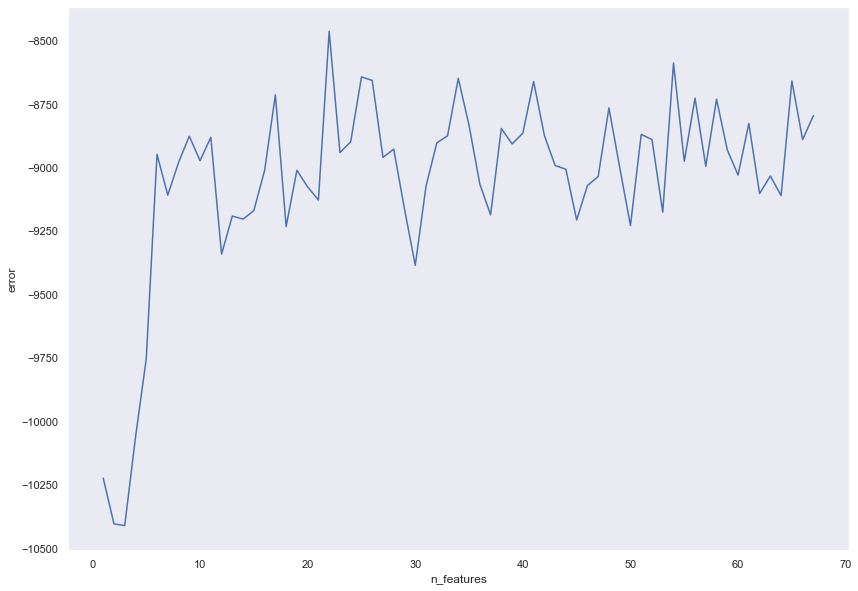

In [74]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [75]:
feature_ranking = pd.Series(rfe.ranking_, index=x_cols)

In [76]:
feature_ranking.sort_values()

primary_size                        1
area_name_Ullern                    1
area_name_Nordre Aker               1
area_name_Frogner                   1
area_name_Østensjø                  1
energy_letter_G                     1
energy_letter_D                     1
ownership_type_Eier (Selveier)      1
ownership_type_Annet                1
property_type_Leilighet             1
property_type_Garasje/Parkering     1
new_building_True                   1
floor                               1
construction_year                   1
property_type_Enebolig              1
lng_pow_2                           1
time_s                              1
lat_pow_2                           1
lng_x_lat                           1
lat                                 1
num_bedrooms                        1
lng                                 1
area_name_Vestre Aker               2
area_name_HURDAL                    3
area_name_Grorud                    4
area_name_GJERDRUM                  5
area_name_St

In [77]:
selected_features = list(feature_ranking[feature_ranking <= 3].index)

# Fit Model

In [78]:
pipeline.fit(X_train[selected_features], y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [79]:
pred = pipeline.predict(X_test[selected_features])

In [80]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

# Draw Learning Curves

In [81]:
learning_curve_res = get_learning_curves(pipeline, X_train[selected_features], y_train, score='neg_median_absolute_error')

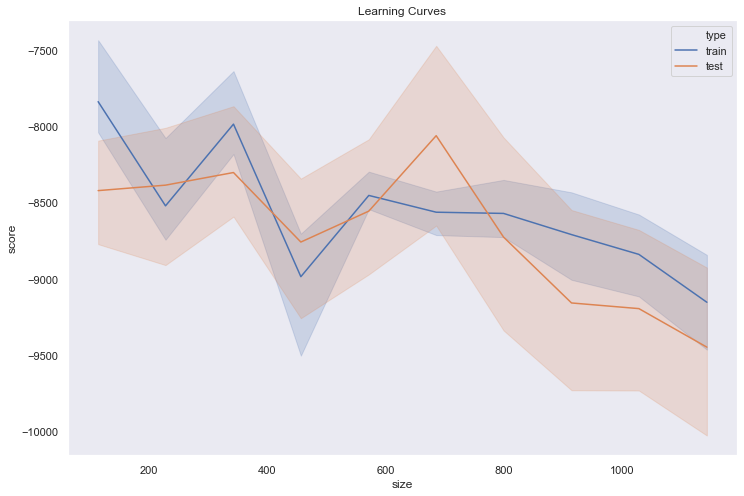

In [82]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [83]:
cv_res = get_cv_res(pipeline,
                    X_train[selected_features],
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [84]:
print_cv_res(cv_res)

Mean fit_time, 0.11
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -9351.45
Mean test_r2, 0.62
Mean test_explained_variance, 0.64
Mean test_max_error, -76271.58


# Display Feature Importances

In [85]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=selected_features).sort_values(ascending=True)

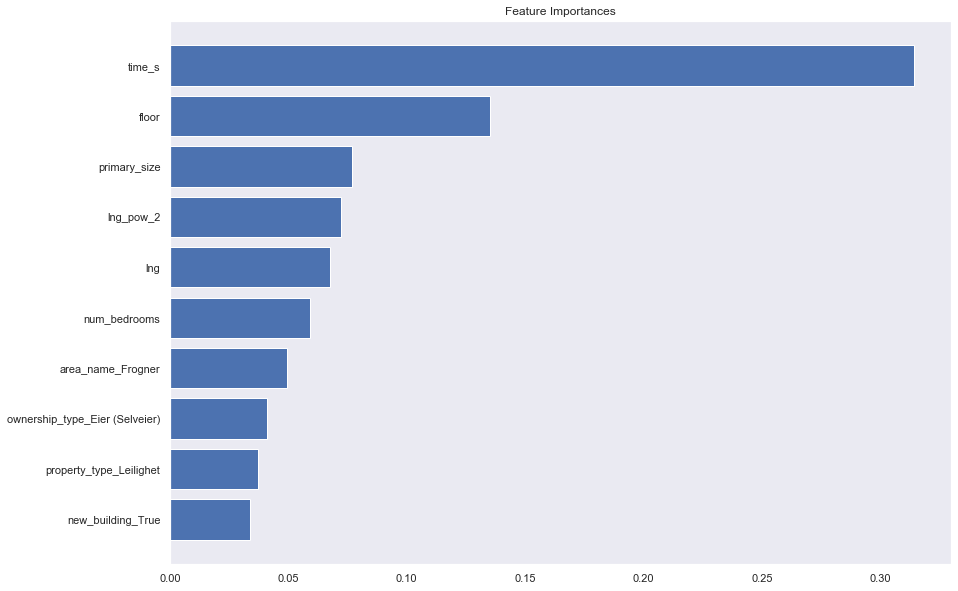

In [86]:
top_n = 10
to_plot = feature_importances[-10:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With NLP

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [88]:
stop_words = ['av', 'og', 'til', 'over', 'fra', 'om',
              'den', 'det', 'denne', 'dette', 'ved',
              'in', 'inn', 'en', 'opp', 'ikke', 'oss',
              'for', 'du', 'fortsatt', 'flere', 'eller',
              'hele', 'her', 'men', 'kan', 'meget',
              'ingen', 'inntil', 'mer']

real_estate_terms = ['solgt', 'informasjon', 'bygget',
                     'leiligheter', 'salg', 'solgte', 'bell']

other_terms = ['inkl', 'nn', 'dok', 'str', 'avg', 'yt',
               'kl', 'kj', 'hj', 'schl', 'nyg']

stop_words = stop_words + real_estate_terms + other_terms

In [89]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                   token_pattern = r'[A-z\-]{3,}',
                                   strip_accents=None,
                                   lowercase=True,
                                   stop_words=stop_words,
                                   # vocabulary=
                                   min_df=1,
                                   max_features = 5000)

In [90]:
vectorized_full_desc = count_vectorizer.fit_transform(data_sample_from_new_buildings[data_sample_from_new_buildings.index.isin(model_data.index)].short_description)

In [91]:
tfidf_transformer = TfidfTransformer()

In [92]:
tfidf = tfidf_transformer.fit_transform(vectorized_full_desc)

In [93]:
tfidf

<2045x1858 sparse matrix of type '<class 'numpy.float64'>'
	with 21474 stored elements in Compressed Sparse Row format>

In [94]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(tfidf,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [95]:
estimator.fit(X_text_train, y_text_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [96]:
y_text_pred = estimator.predict(X_text_test)

# Draw Learning Curves

In [97]:
learning_curve_res = get_learning_curves(estimator,
                                         X_text_train,
                                         y_text_train,
                                         score='neg_median_absolute_error')

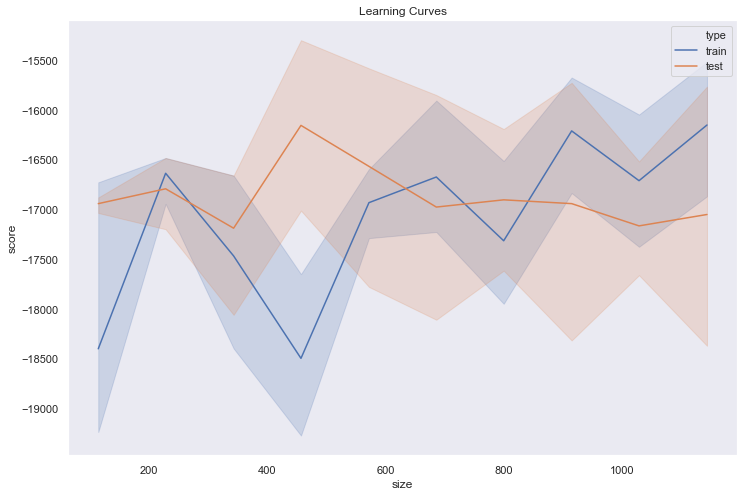

In [98]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [99]:
cv_res = get_cv_res(estimator,
                    X_text_train,
                    y_text_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [100]:
print_cv_res(cv_res)

Mean fit_time, 0.06
Mean score_time, 0.01
Mean test_neg_median_absolute_error, -17311.18
Mean test_r2, 0.05
Mean test_explained_variance, 0.09
Mean test_max_error, -85326.76


In [101]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

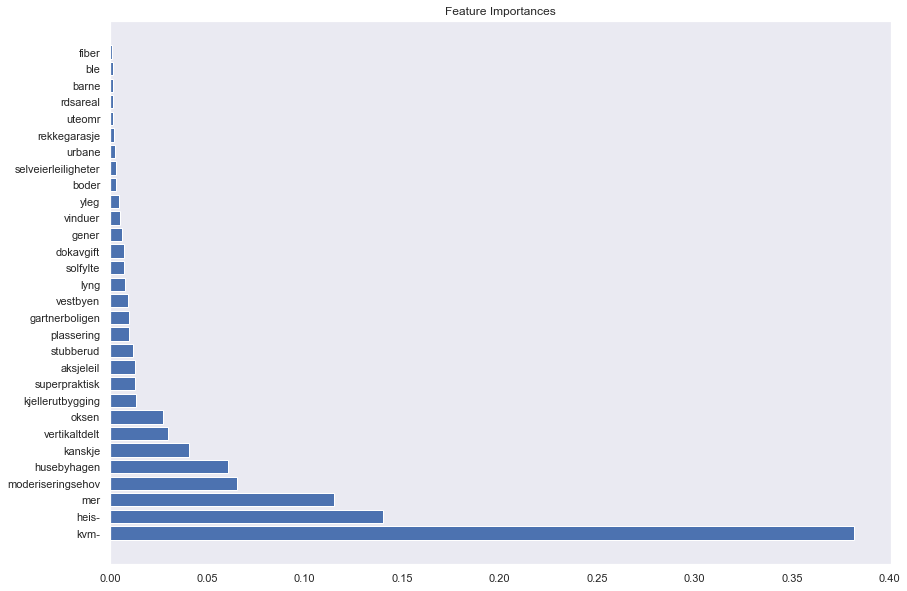

In [102]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With All Features

In [103]:
# all_features = scipy.sparse.hstack([vectorized_full_desc, X_sparse])
all_features = scipy.sparse.hstack([tfidf, X_sparse])

In [104]:
all_features

<2045x1925 sparse matrix of type '<class 'numpy.float64'>'
	with 51841 stored elements in COOrdinate format>

In [105]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(all_features,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [106]:
estimator.fit(X_full_train, y_full_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [107]:
y_pred = estimator.predict(X_full_test)

# Draw Learning Curves

In [108]:
learning_curve_res = get_learning_curves(estimator,
                                         X_full_train,
                                         y_full_train,
                                         score='neg_median_absolute_error')

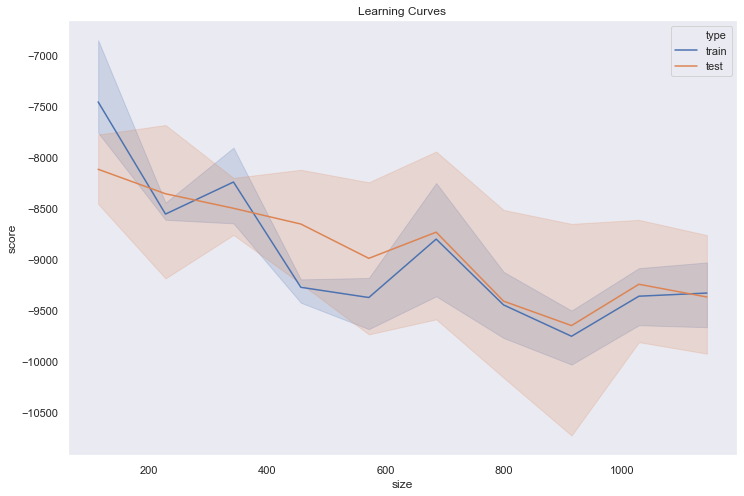

In [109]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [110]:
cv_res = get_cv_res(estimator,
                    X_full_train,
                    y_full_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [111]:
print_cv_res(cv_res)

Mean fit_time, 0.21
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -9741.67
Mean test_r2, 0.61
Mean test_explained_variance, 0.65
Mean test_max_error, -80504.05


# Display Feature Importances

In [112]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()) + list(x_cols)).sort_values(ascending=True)

In [113]:
feature_importances.sort_values(ascending=False)[:30]

time_s                            0.238229
floor                             0.078731
area_name_Frogner                 0.063877
primary_size                      0.056577
construction_year                 0.047500
husebyhagen                       0.043681
lng_pow_2                         0.040134
praktisk                          0.039666
lng                               0.036795
kanskje                           0.035613
rpreget                           0.029689
boder                             0.028808
heis-                             0.026623
ownership_type_Eier (Selveier)    0.026106
num_bedrooms                      0.023180
kvm-                              0.019154
gartnerboligen                    0.016407
lng_x_lat                         0.016396
kjellerutbygging                  0.013894
property_type_Leilighet           0.012781
gener                             0.012106
energy_letter_G                   0.011896
selveierleil                      0.011018
urbane     

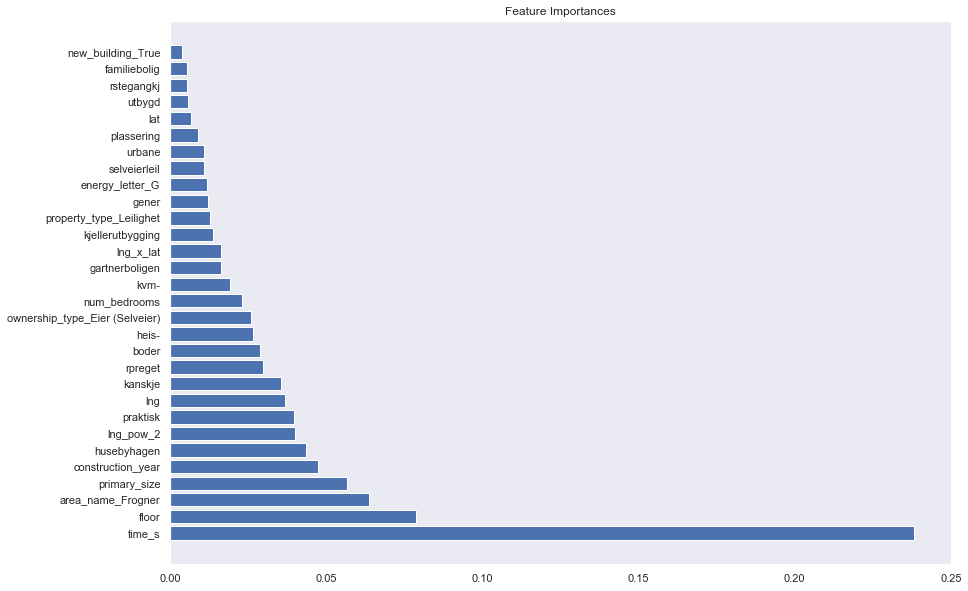

In [114]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [115]:
vocab = pd.Series(list(count_vectorizer.vocabulary_.values()), index=count_vectorizer.vocabulary_.keys())

In [116]:
vocab.sort_values(ascending=False)[:10]

ytterkant       1857
ytre            1856
ypperlig        1855
yper            1854
ype             1853
youngstorget    1852
york            1851
yleg            1850
yhuset          1849
yes             1848
dtype: int64

# TODO
* Draw learning curves on multiple metrics
* Add recursive feature elimination to the NLP processing